In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import quantumpropagator
import matplotlib.pyplot as plt
from ipywidgets import interact,fixed #, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
dataDict = np.load('datanewoneWithNACnow.npy')[()]

4.27435703085393


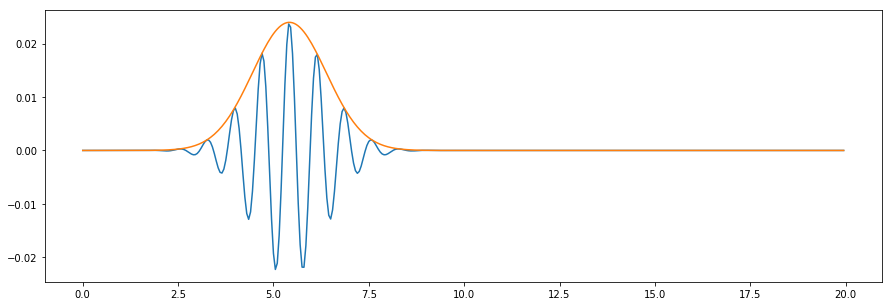

In [3]:
%matplotlib inline

pulseX = [0.024,0.21,40,0,224]
pulseY = [0.024,0.06,40,0,274]
pulseZ = [0.024,0.06,40,0,274]

# graph length in fs
fs = 20
# graph resolution
reso = 20

# actual plotting array
fsarray = (np.arange(fs*reso))/reso
a = qp.fromFsToAu(fsarray)
b = qp.pulZe(a,pulseX)
c = qp.envel(a,pulseX[0],pulseX[2],pulseX[4])

fig = plt.figure(figsize=(15,5))

plt.plot(fsarray,b)
plt.plot(fsarray,c)

e = 2 * np.pi/(pulseX[2])

print(qp.fromHartoEv(e))

In [4]:
def expARR(array,howmany,direction=None):
    direction = direction or 'both'
    dx = array[1]-array[0]
    after = (array[-1] + (dx * np.arange(howmany+1)))[1:]
    before = np.flip((array[0] - (dx * np.arange(howmany+1)))[1:],0)
    if direction == 'both':
        return np.concatenate((before,array,after))
    elif direction == 'dx':
        return np.concatenate((array,after))
    elif direction == 'sx':
        return np.concatenate((before,array))
    
phiV, gamV, theV = qp.fromLabelsToFloats(dataDict)

phis = qp.labTranformA(dataDict['phis'])
gams = qp.labTranformA(dataDict['gams'])
thes = qp.labTranformA(dataDict['thes'])

phiL = len(phis)
gamL = len(gams)
theL = len(thes)

In [5]:
# This part creates the potentials

import scipy.io as sio

# saveNew_matlab_Vector = False
# #phi_L, gam_L, the_L, nstates =  potential.shape

nstates = 8

# if saveNew_matlab_Vector:
#     allstates = {}

#     for s in range(nstates):
#         ground = potential[:,:,:,s]
#         tupl = ground.shape
#         ground.shape,phiV.shape,gamV.shape,theV.shape

#         phi_mesh, gam_mesh, the_mesh =  np.meshgrid(phiV,gamV,theV, indexing='ij')

#         phi_prime = phi_mesh.reshape(-1,1)
#         gam_prime = gam_mesh.reshape(-1,1)
#         the_prime = the_mesh.reshape(-1,1)

#         X = np.concatenate((phi_prime,gam_prime,the_prime), axis=1)

#         y = ground.reshape(-1,1)

#         poly = PolynomialFeatures(degree=10)

#         X_ = poly.fit_transform(X)

#         clf = LinearRegression()
#         clf.fit(X_, y)

#         prediction = clf.predict(X_)
#         prediction_reshaped = prediction.reshape(tupl)
#         stringName = 'TDM{}'.format(s)
#         allstates[stringName] = prediction_reshaped

#     sio.savemat('np_vector.mat', allstates)

aaa = sio.loadmat('tdm.mat')
new = aaa['v0']
new_phi_L, new_gam_L, new_the_L = new.shape
ext_potential = np.empty((new_phi_L, new_gam_L, new_the_L, nstates))

phi_cayo = expARR(phiV,15,'both')
gam_cayo = expARR(gamV,15,'both')
the_cayo = expARR(theV,30,'both')

phi_mesh_cayo, gam_mesh_cayo, the_mesh_cayo =  np.meshgrid(phi_cayo,gam_cayo,the_cayo, indexing='ij')

for s in range(nstates):
    label = 'v{}'.format(s)
    ext_potential[:,:,:,s] = aaa[label]
    
zero = np.amin(ext_potential)
ext_potential = ext_potential - zero

In [6]:
# minimum index
ij_min = np.unravel_index(ext_potential.argmin(), ext_potential.shape)
phi_min,gam_min,the_min,ground_min = ij_min
ij_min

(29, 28, 55, 0)

In [7]:
def graphichetto(pulseXX, label, phi_slice, gam_slice, save=None, internal_coord=None):
    save = save or False
    internal_coord = internal_coord or False
    sigma = pulseXX[2]
    omega = pulseXX[1]

    # I will cut the cube at phi_min and gamma_min
    potAU = ext_potential[phi_slice,gam_slice]
    
    # change dimensions
    pot = qp.fromHartoEv(potAU)
    
    # create labels
    thes = qp.labTranformA(dataDict['thes'])

    # create the 4 panels
    fig, ([ax, ax0], [ax1, ax2]) = plt.subplots(2,2, gridspec_kw = {'height_ratios':[3, 1], 'width_ratios':[3, 1]},figsize=(15,10))
    ax2.axis('off')
    
    plt.rcParams.update({'font.size': 15})
    
    xmin = the_cayo[the_min]
    puntoMin = [the_min,0]


    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'mediumpurple']
    for iii in range(nstates):
        if internal_coord:
            ax.plot(the_cayo, potAU[:,iii], ls='-', lw=1.5, color=colors[iii]);
            ax.set_ylabel('Potential Energy (Hartree)')
        else:
            ax.plot(the_cayo, pot[:,iii], ls='-', lw=1.5, color=colors[iii]);
            ax.set_ylabel('Potential Energy (eV)')

    #ax.set_xlabel('q')
    #ax.set_ylabel('Potential Energy')

    # fs extent of GRAPH
    fs = 50
    # resolution of graph
    reso = 20
    
    # actaual values for the pulse
    fsarray = (np.arange(fs*reso))/reso
    
    # I need the fsarray in AU to call the internal functions pulZe and envel
    a = qp.fromFsToAu(fsarray)
    

    f = qp.pulZe(a,pulseXX)

    title_thing = r'AU -> $E$={:5.2f}  $\omega$={:5.2f}  $\sigma$={:5.2f}  $\phi$={:5.2f}  $t_0$={:5.2f}'.format(pulseXX[0],pulseXX[1],pulseXX[2],pulseXX[3],pulseXX[4])
    ax.set_title(title_thing)
    
    c = qp.envel(a,pulseXX[0],pulseXX[2],pulseXX[4])


    # but then I plot on femtoseconds
    if internal_coord:
        ax1.plot(a,f)
        ax1.plot(a,c)
        ax1.set_xlabel('Time (AU)')        
    else:
        ax1.plot(fsarray,f)
        ax1.plot(fsarray,c)
        ax1.set_xlabel('Time (fs)')
    
    #labels

    ax.set_xlabel(r'$\theta$ (rad)')

    # sigma in energy space
  
    e = 1/(sigma)
    #print('e = {}'.format(e))
    #e = 2*np.pi/(sigma)
    #e = (np.pi**2)*sigma**2
    #e = 1/(2 * np.pi*(sigma))
    
    # the 67% is sigma
    # the 95% interval is 2 sigma. This is why e*2
    # first and second are still in hartree.
    
    first_half = pulseXX[1] - (e * np.sqrt(2*(np.log(2))))
    second_half = pulseXX[1] + (e *np.sqrt(2*(np.log(2))))

    first = pulseXX[1] - (e)
    second = pulseXX[1] + (e)
    first2 = pulseXX[1] - (2*e)
    second2 = pulseXX[1] + (2*e)

    # grey band
    if internal_coord:
        #ax.fill_between(the_cayo, first2, second2, color='whitesmoke')
        ax.fill_between(the_cayo, first_half, second_half, color='gainsboro') # grey bar
        ax.plot([xmin, xmin], [first_half, second_half], 'k-', lw=2) # black line
    else:
        #ax.fill_between(the_cayo, qp.fromHartoEv(first2), qp.fromHartoEv(second2), color='whitesmoke')
        ax.fill_between(the_cayo, qp.fromHartoEv(first_half), qp.fromHartoEv(second_half), color='gainsboro')
        ax.plot([xmin, xmin], [qp.fromHartoEv(first_half),qp.fromHartoEv(second_half)], 'k-', lw=2)
    
    maxValue_in_ev = qp.fromEvtoHart(np.amax(pot))
    w = np.linspace(0,maxValue_in_ev,800)

    # This is the other gaussian in reciprocal space.
    other = np.exp(-(w-omega)**2 / (2 * e**2))
    
    #    other = np.exp(-(w-omega)**2 * e)
    
    if internal_coord:
        ax0.plot(other,w)
    else:
        ax0.plot(qp.fromHartoEv(other),qp.fromHartoEv(w))
    
    
    ax0.set_xticks([])
    
    fig.tight_layout()
    
    if save:
        name_fig = 'pulse{:04d}.png'.format(label)
        fig.savefig(name_fig, dpi=300)


    

In [8]:
omega = 1.54980/27.211
sigma = 100
qp.pulse(800,0.024,omega,sigma,0,800)
number = 2*np.sqrt(2*(np.log(2)))

In [9]:
def graphichetto_handler(inter,saves,phi_cut,gam_cut):
    i = 0
    
    #full Width at mid height
    FWMH = 6

    # sigma in FS - the 95% of the gaussian is 4 sigma
    sigmaFS = FWMH/(number)

    # sigma is AU
    sigma = qp.fromFsToAu(sigmaFS)
#W    sigma = 40

    # hartree
    
    # This is the value of omega for 800 IR pulse
    omega = 1.54980/27.211
    
    #omega = 0.27

    pulseXX = [0.04,0.22,35.11,0,400]
    
    graphichetto(pulseXX, i, phi_cut, gam_cut, save=saves, internal_coord=inter)

interact(graphichetto_handler,
         inter = widgets.Checkbox(value=False, description='Atomic Units'),
         saves = widgets.Checkbox(value=False, description='save images'),
         phi_cut = widgets.IntSlider(min=0,max=phi_cayo.size-1,step=1,value=phi_min,continuous_update=False),
         gam_cut = widgets.IntSlider(min=0,max=gam_cayo.size-1,step=1,value=gam_min,continuous_update=False),
        );

A Jupyter Widget

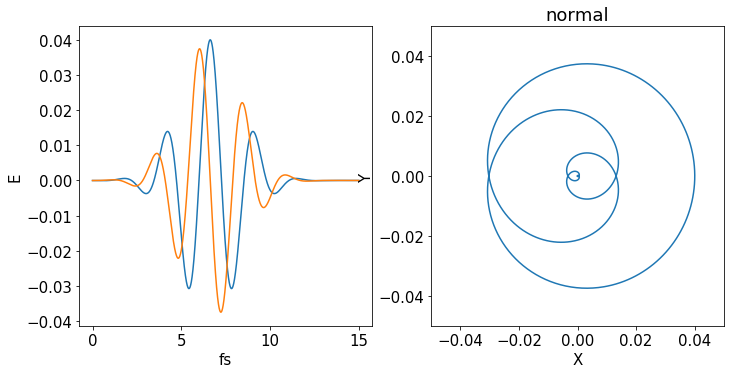

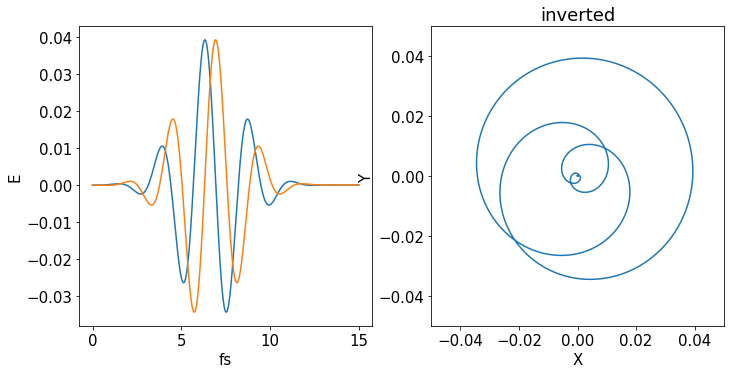

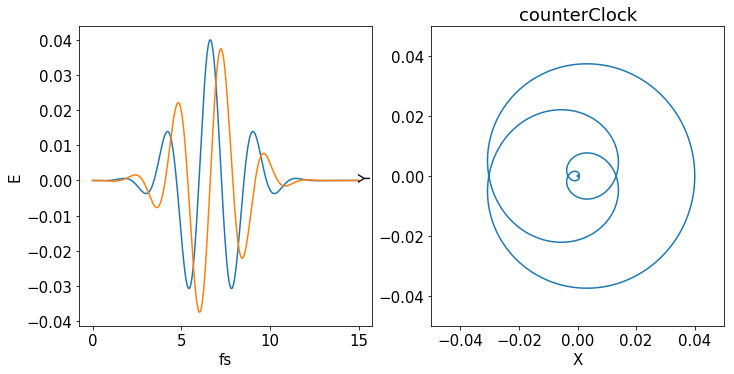

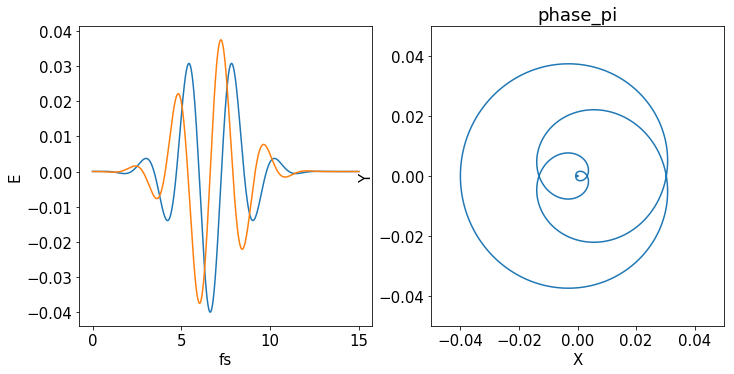

In [78]:

def phaseGraph(pulse3_tuple,fs,reso,first,second,labeol):
    '''
    draw a x on y graph
    '''
    x,y = pulse3_tuple[first],pulse3_tuple[second]
    
    names = ['X','Y','Z']
    
    name_first,name_second = names[first], names[second]

    # actaual values for the pulse
    fsarray = (np.arange(fs*reso))/reso
    
    # I need the fsarray in AU to call the internal functions pulZe and envel
    a = qp.fromFsToAu(fsarray)
    b = qp.pulZe(a,x)        
    c = qp.pulZe(a,y)    
 
    fig, (ax0,ax1) = plt.subplots(1,2,figsize=(10,5))
    fig.tight_layout()

    plt.title(labeol)
    
    ax0.set_xlabel('fs')
    ax0.set_ylabel('E')
    ax1.set_xlabel(name_first)
    ax1.set_ylabel(name_second)
    
    ax0.plot(fsarray,b)
    ax0.plot(fsarray,c)
    
    ax1.set_xlim(-0.05,0.05)
    ax1.set_ylim(-0.05,0.05)
    ax1.plot(b,c)

def gimme_phases(phi1,phi2):
    '''
    given the two phases, returns a z_dummy IR pulse with different phases to feed the graph
    '''
    pulsino = [[0.04,0.06,70.22,phi1,274],[0.04,0.06,70.22,phi2,274],[1,1,1,1,1]] 
    return pulsino


pulseWant = gimme_phases(np.pi/4,-np.pi/4)
pulse2 = gimme_phases(0,np.pi/2)
pulse3 = gimme_phases(0,3*(np.pi/2))
pulse4 = gimme_phases(np.pi,3*(np.pi/2))

phaseGraph(pulse2,15,200,0,1,'normal')
phaseGraph(pulseWant,15,200,0,1,'inverted')
phaseGraph(pulse3,15,200,0,1, 'counterClock')
phaseGraph(pulse4,15,200,0,1,'phase_pi')
